In [1]:
import cached
import cpr_gym
import git
import gym
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pathlib
import psutil
import seaborn as sns
import threadpoolctl
import time
import torch
import warnings
from pandarallel import pandarallel
from tqdm.notebook import tqdm

tqdm.pandas()
pandarallel.initialize(progress_bar=True, nb_workers=psutil.cpu_count(logical=False))
torch.set_num_threads = 1

print("cpr_lib_version: " + cpr_gym.engine.cpr_lib_version)

repo = git.Repo(".", search_parent_directories=True)
repo.working_tree_dir
os.chdir(repo.working_tree_dir)

cpr_gym: Editable install detected. Load DLL from _build directory.
cpr_gym: __version__ = v0.7.0-99-g6b9476e-dirty (engine: v0.7.0-90-gf9bd542-dirty)
INFO: Pandarallel will run on 6 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
cpr_lib_version: v0.7.0-90-gf9bd542-dirty


In [2]:
# Fix model import
import sys
import experiments.train.cfg_model as cfg_model

sys.modules[
    "cfg_model"
] = cfg_model  # cfg_model should be moved somewhere else, I guess

In [3]:
episode_len = 2048
n_episodes = 100
batches = [
    # "2023-01-10_tailstorm-8-constant",
    # "2023-01-11_nakamoto", # broken, is it because is was trained on python3.11?
    # "2023-01-11_bk-8",
    # "2023-01-12_nakamoto",
    # "2023-01-13_full",
    "2023-01-18_all-protos-0",
    "2023-01-19_nakamoto-0",
    "2023-01-19_all-protos-0",
    "2023-01-20_tailstorm-0",
    "2023-01-20_tailstorm-discount",
    "2023-01-23_non-discount-low-alpha",
    "2023-01-25_bk-8-long-0",  # not so long since I forgot to push the changes before launch
    "2023-01-25_tailstorm-discount-0",
    "2023-02-01-alpha50",
]

protocol_args = dict(
    nakamoto=[],
    bk=["k", "reward"],
    tailstorm=["k", "reward", "subblock_selection"],
    tailstormll=["k", "reward", "subblock_selection"],
    tailstormjune=["k", "reward"],
)

env_name = "cpr_gym:cpr-v0"


def env_kwargs_of_row(x):
    return dict(
        protocol=x.protocol,
        protocol_args={k: x[k] for k in protocol_args[x.protocol]},
        alpha=x.alpha if "alpha" in x.keys() else 0,
        gamma=x.gamma if "gamma" in x.keys() else 0,
        defenders=42,
    )

# Data generation

## Find trained models

In [4]:
def models():
    for batch in batches:
        for m in pathlib.Path(f"data/models/{batch}").glob("ppo-*.zip"):
            frag = m.stem.split("-")
            protocol = frag.pop(1)
            if protocol == "nakamoto":
                yield dict(
                    protocol=protocol,
                    k=1,
                    reward="constant",
                    subblock_selection="n/a",
                    alpha=int(frag.pop(1).removeprefix("alpha")) / 100,
                    gamma=int(frag.pop(1).removeprefix("gamma")) / 100,
                    policy="-".join(frag),
                    path=m,
                )
            elif protocol in ["bk", "bkll"]:
                yield dict(
                    protocol=protocol,
                    k=int(frag.pop(1)),
                    reward="constant",
                    subblock_selection="n/a",
                    alpha=int(frag.pop(1).removeprefix("alpha")) / 100,
                    gamma=int(frag.pop(1).removeprefix("gamma")) / 100,
                    policy="-".join(frag),
                    path=m,
                )
            elif protocol in ["tailstorm", "tailstormll"]:
                yield dict(
                    protocol=protocol,
                    k=int(frag.pop(1)),
                    reward=frag.pop(1),
                    subblock_selection="heuristic",
                    alpha=int(frag.pop(1).removeprefix("alpha")) / 100,
                    gamma=int(frag.pop(1).removeprefix("gamma")) / 100,
                    policy="-".join(frag),
                    path=m,
                )
            else:
                raise Exception(f"unsupported protocol: {protocol}")


models = pd.DataFrame(models()).assign(kind="trained", reuse="-")
models

protocol  k    reward subblock_selection  alpha  gamma  \
0     nakamoto  1  constant                n/a   0.45   0.05   
1           bk  8  constant                n/a   0.35   0.50   
2     nakamoto  1  constant                n/a   0.45   0.05   
3    tailstorm  8  constant          heuristic   0.40   0.05   
4    tailstorm  8  constant          heuristic   0.35   0.50   
..         ... ..       ...                ...    ...    ...   
589         bk  8  constant                n/a   0.50   0.50   
590   nakamoto  1  constant                n/a   0.50   0.05   
591  tailstorm  8  discount          heuristic   0.50   0.50   
592  tailstorm  8  discount          heuristic   0.50   0.05   
593   nakamoto  1  constant                n/a   0.50   0.95   

                    policy                                               path  \
0    ppo-exp-l0snb7rh-last  data/models/2023-01-18_all-protos-0/ppo-nakamo...   
1    ppo-cut-jtbk5801-best  data/models/2023-01-18_all-protos-0/ppo-bk-8-a...   
2    ppo-raw-jxh7vrb1-last  data/models/2023-01-18_all-protos-0/ppo-nakamo...   
3    ppo-exp-3m3o72z0-last  data/models/2023-01-18_all-protos-0/ppo-tailst...   
4    ppo-exp-mjli3xrv-best  data/models/2023-01-18_all-protos-0/ppo-tailst...   
..                     ...                                                ...   
589  ppo-cut-ittori1b-last  data/models/2023-02-01-alpha50/ppo-bk-8-alpha5...   
590  ppo-raw-ritfz31h-best  data/models/2023-02-01-alpha50/ppo-nakamoto-al...   
591  ppo-exp-y6m4puew-best  data/models/2023-02-01-alpha50/ppo-tailstorm-8...   
592  ppo-cut-gjewruub-last  data/models/2023-02-01-alpha50/ppo-tailstorm-8...   
593  ppo-exp-qwwn71e9-last  data/models/2023-02-01-alpha50/ppo-nakamoto-al...   

        kind reuse  
0    trained     -  
1    trained     -  
2    trained     -  
3    trained     -  
4    trained     -  
..       ...   ...  
589  trained     -  
590  trained     -  
591  trained     -  
592  trained     -  
593  trained     -  

[594 rows x 10 columns]

In [5]:
# reuse some trained models for other settings
models = pd.concat(
    [
        models,
        models.query('protocol == "tailstorm" and reward == "constant"').assign(
            reuse="proto", reward="discount"
        ),
        models.query("gamma != 0.05").assign(reuse="gamma05", gamma=0.05),
        models.query("gamma != 0.50").assign(reuse="gamma50", gamma=0.50),
        models.query("gamma != 0.95").assign(reuse="gamma95", gamma=0.95),
    ]
)
models = models.assign(reused=[x != "-" for x in models.reuse])
# models

## Find hard-coded policies

In [25]:
def hard_coded_policies(models):
    for _idx, x in (
        models[["protocol", "k", "reward", "subblock_selection", "gamma", "alpha"]]
        .drop_duplicates()
        .iterrows()
    ):
        kwargs = env_kwargs_of_row(x)
        env = gym.make(env_name, **kwargs)
        for p in env.policies():
            x = x.copy()
            x["policy"] = p
            yield x


hard_coded_policies = (
    pd.DataFrame(hard_coded_policies(models))
    .reset_index(drop=True)
    .assign(kind="hard-coded", path="n/a", reuse="-", reused=False)
)
hard_coded_policies
# hard_coded_policies.drop(columns=["alpha", "gamma"]).drop_duplicates()

protocol  k    reward subblock_selection  gamma  alpha  \
0     nakamoto  1  constant                n/a   0.05   0.45   
1     nakamoto  1  constant                n/a   0.05   0.45   
2     nakamoto  1  constant                n/a   0.05   0.45   
3     nakamoto  1  constant                n/a   0.05   0.45   
4           bk  8  constant                n/a   0.50   0.35   
..         ... ..       ...                ...    ...    ...   
289         bk  8  constant                n/a   0.50   0.50   
290  tailstorm  8  constant          heuristic   0.50   0.50   
291  tailstorm  8  constant          heuristic   0.50   0.50   
292  tailstorm  8  constant          heuristic   0.50   0.50   
293  tailstorm  8  constant          heuristic   0.50   0.50   

                   policy        kind path reuse  reused  
0    sapirshtein-2016-sm1  hard-coded  n/a     -   False  
1         eyal-sirer-2014  hard-coded  n/a     -   False  
2                  simple  hard-coded  n/a     -   False  
3                  honest  hard-coded  n/a     -   False  
4                 selfish  hard-coded  n/a     -   False  
..                    ...         ...  ...   ...     ...  
289                honest  hard-coded  n/a     -   False  
290      override-catchup  hard-coded  n/a     -   False  
291        override-block  hard-coded  n/a     -   False  
292         release-block  hard-coded  n/a     -   False  
293                honest  hard-coded  n/a     -   False  

[294 rows x 11 columns]

## Run simulations

In [7]:
models_and_hard_coded_policies = pd.concat(
    [models, hard_coded_policies], ignore_index=True
)


def episodes():
    for i in range(0, n_episodes):
        yield models_and_hard_coded_policies.assign(episode=i)


episodes = pd.concat(episodes(), ignore_index=True)


def measure_row(x, **kwargs):
    kwargs |= env_kwargs_of_row(x)
    kwargs["episode_len"] = episode_len
    kwargs["seed"] = getattr(x, "episode", None)
    if x.kind == "trained":
        res = cached.measure_trained(env_name, x.path, **kwargs)
    elif x.kind == "hard-coded":
        res = cached.measure_hardcoded(env_name, x.policy, **kwargs)
    else:
        assert False
    return pd.Series(res)


d = episodes.sample(
    frac=1
)  # shuffle for better load balancing in case of cached measurements

# results = d.progress_apply(measure_row, axis=1)
with threadpoolctl.threadpool_limits(limits=1):
    results = d.parallel_apply(measure_row, axis=1)

episodes = pd.concat([d, results], axis=1).sort_index()

# list(episodes.columns)

In [8]:
# save episode data for re-use in other notebooks
episodes.to_pickle("experiments/rl-eval/episodes.pkl")

# Find optimal policies

In [9]:
scenario = [
    "protocol",
    "k",
    "reward",
    "subblock_selection",
    "alpha",
    "gamma",
    "kind",
    "reused",
]
policy = ["policy", "path"]
# d = episodes.query("kind=='hard-coded'")
d = episodes
opt_means = (
    d.assign(episode_reward=d.episode_reward_attacker / d.episode_progress)
    .groupby(scenario + policy, as_index=False)
    .episode_reward.mean()
)
opt_policies = (
    opt_means.loc[opt_means.groupby(scenario).episode_reward.idxmax()]
    .drop(columns=["episode_reward"])
    .reset_index(drop=True)
)
display(opt_policies.drop(columns=["path"]))

opt_episodes = opt_policies.join(d.set_index(scenario + policy), on=scenario + policy)
# display("opt_episodes columns", list(opt_episodes.columns))

protocol  k    reward subblock_selection  alpha  gamma        kind  \
0           bk  8  constant                n/a    0.2   0.05  hard-coded   
1           bk  8  constant                n/a    0.2   0.05     trained   
2           bk  8  constant                n/a    0.2   0.05     trained   
3           bk  8  constant                n/a    0.2   0.50  hard-coded   
4           bk  8  constant                n/a    0.2   0.50     trained   
..         ... ..       ...                ...    ...    ...         ...   
247  tailstorm  8  discount          heuristic    0.5   0.50     trained   
248  tailstorm  8  discount          heuristic    0.5   0.50     trained   
249  tailstorm  8  discount          heuristic    0.5   0.95  hard-coded   
250  tailstorm  8  discount          heuristic    0.5   0.95     trained   
251  tailstorm  8  discount          heuristic    0.5   0.95     trained   

     reused                 policy  
0     False                 honest  
1     False  ppo-raw-vsvy2ww9-best  
2      True  ppo-cut-i26ts374-best  
3     False                 honest  
4     False  ppo-raw-vc9fsxxs-best  
..      ...                    ...  
247   False  ppo-cut-02tji18a-best  
248    True  ppo-exp-d601dmvf-best  
249   False       override-catchup  
250   False  ppo-exp-d601dmvf-best  
251    True  ppo-exp-h9vyhhee-last  

[252 rows x 9 columns]

# Compare RL against best hard-coded

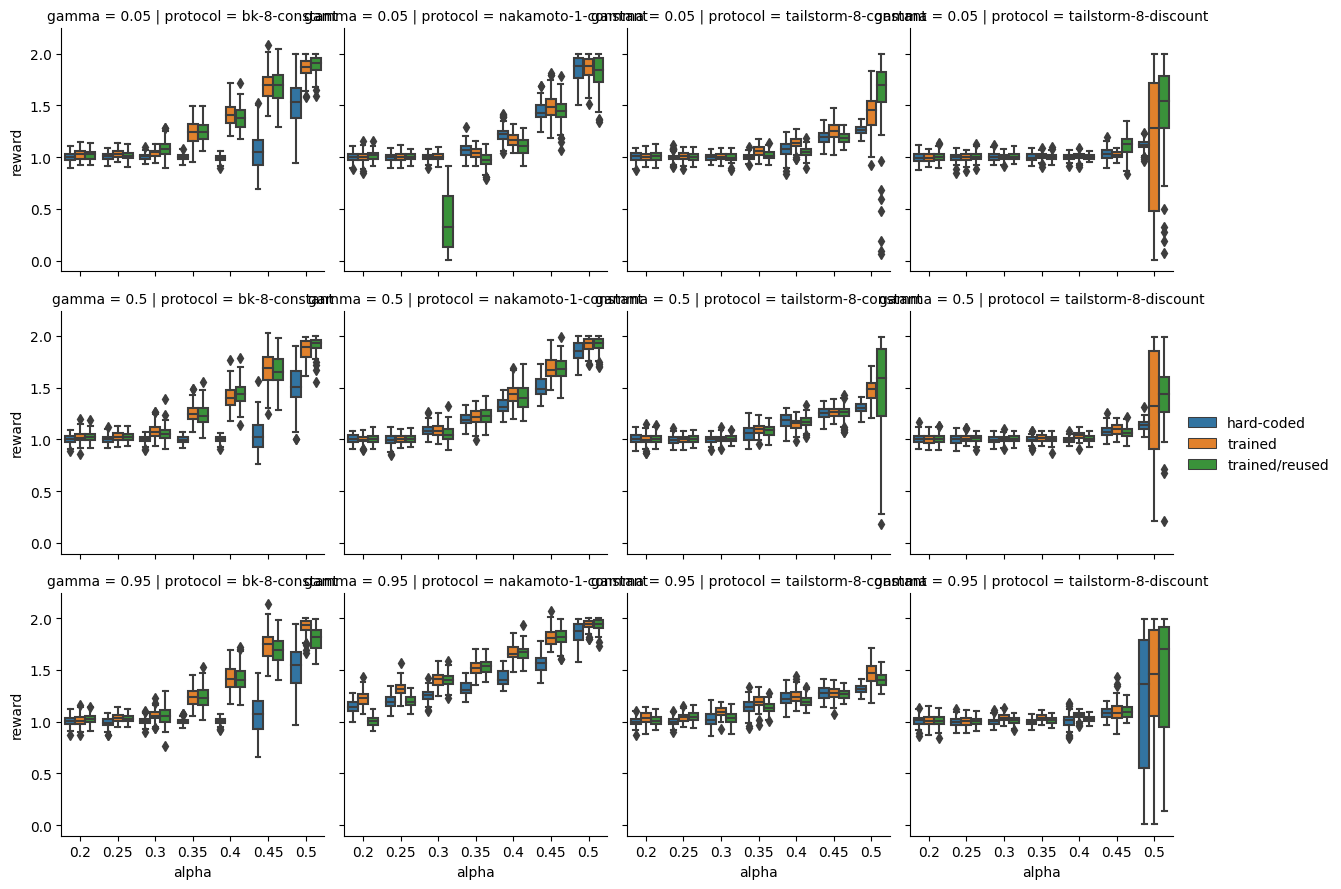

In [10]:
def rl_vs_hard_coded_bp(objective, label="reward"):
    d = opt_episodes.copy()
    d.loc[d.reused, "kind"] = "trained/reused"
    d = (
        d.assign(
            protocol=d.protocol + "-" + d.k.map(str) + "-" + d.reward,
            kind=d.kind.astype("category"),
            __=objective(d),
        )
        .drop(columns=[label], errors="ignore")
        .rename(columns=dict(__=label))
    )
    g = sns.FacetGrid(
        data=d,
        # data=d.query("alpha >= .35"),
        col="protocol",
        row="gamma",
        sharex=True,
        sharey=True,
    )
    g.map_dataframe(
        sns.boxplot,
        x="alpha",
        y=label,
        hue="kind",
        orient="v",
        palette=sns.color_palette(),
    )
    g.add_legend()


## reward per progess (in DAA equilibrium)
# rl_vs_hard_coded(lambda d: d.episode_reward_attacker / d.episode_progress)
## alpha normalizations
rl_vs_hard_coded_bp(lambda d: d.episode_reward_attacker / d.episode_progress / d.alpha)
# rl_vs_hard_coded(lambda d: d.episode_reward_attacker / d.episode_progress - d.alpha)

In [11]:
opt_policies.query('protocol == "tailstorm" and gamma==0.95 and alpha==.45').drop(
    columns=["path"]
)

protocol  k    reward subblock_selection  alpha  gamma        kind  \
177  tailstorm  8  constant          heuristic   0.45   0.95  hard-coded   
178  tailstorm  8  constant          heuristic   0.45   0.95     trained   
179  tailstorm  8  constant          heuristic   0.45   0.95     trained   
240  tailstorm  8  discount          heuristic   0.45   0.95  hard-coded   
241  tailstorm  8  discount          heuristic   0.45   0.95     trained   
242  tailstorm  8  discount          heuristic   0.45   0.95     trained   

     reused                 policy  
177   False         override-block  
178   False  ppo-raw-1acc64rs-best  
179    True  ppo-raw-bw5fuebk-best  
240   False         override-block  
241   False  ppo-cut-i4ho85tu-best  
242    True  ppo-raw-1acc64rs-best

/tmp/ipykernel_17101/3968487956.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  opt_episodes.groupby(


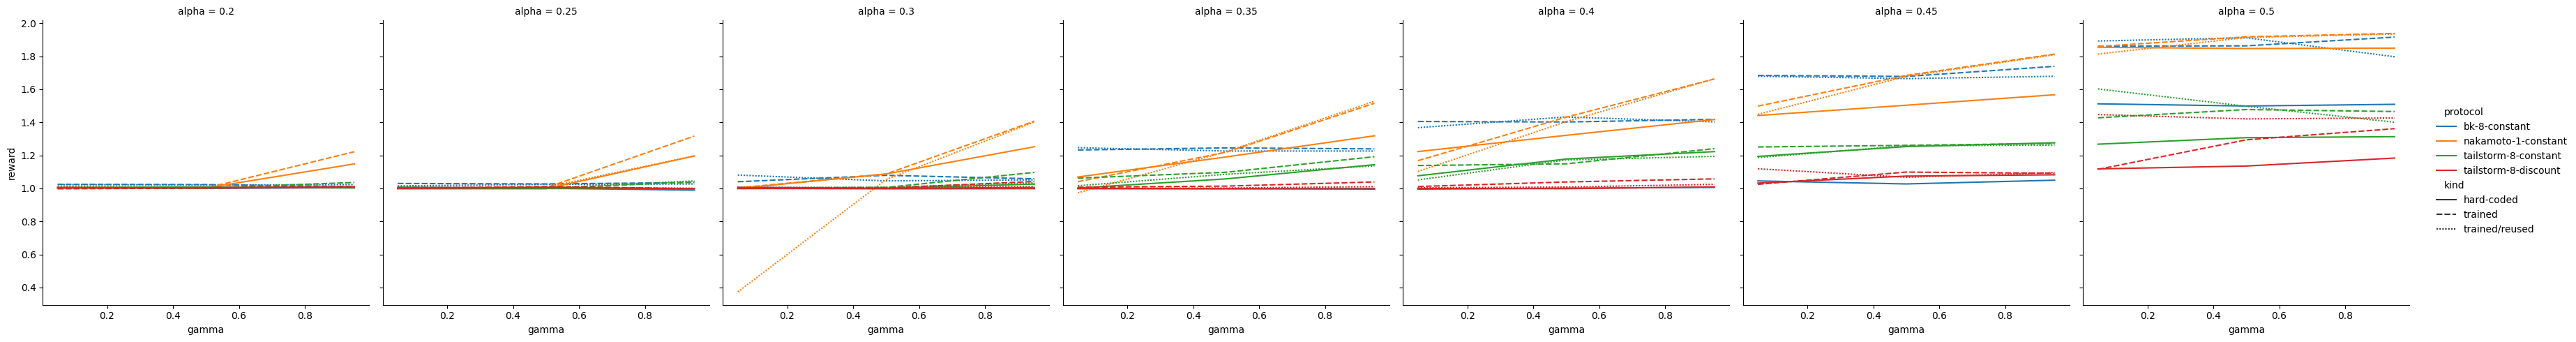

In [12]:
def rl_vs_hard_coded_gamma_lp(objective, label="reward"):
    d = (
        opt_episodes.groupby(
            [
                "protocol",
                "k",
                "reward",
                "subblock_selection",
                "alpha",
                "gamma",
                "kind",
                "reused",
                "policy",
            ]
        )
        .mean()
        .reset_index()
    )
    d.loc[d.reused, "kind"] = "trained/reused"
    d = (
        d.assign(
            protocol=d.protocol + "-" + d.k.map(str) + "-" + d.reward,
            kind=d.kind.astype("category"),
            __=objective(d),
        )
        .drop(columns=[label], errors="ignore")
        .rename(columns=dict(__=label))
    )
    g = sns.relplot(
        data=d,
        kind="line",
        hue="protocol",
        col="alpha",
        x="gamma",
        y=label,
        style="kind",
    )


rl_vs_hard_coded_gamma_lp(
    lambda d: d.episode_reward_attacker / d.episode_progress / d.alpha
)

/tmp/ipykernel_17101/4159778813.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  opt_episodes.groupby(


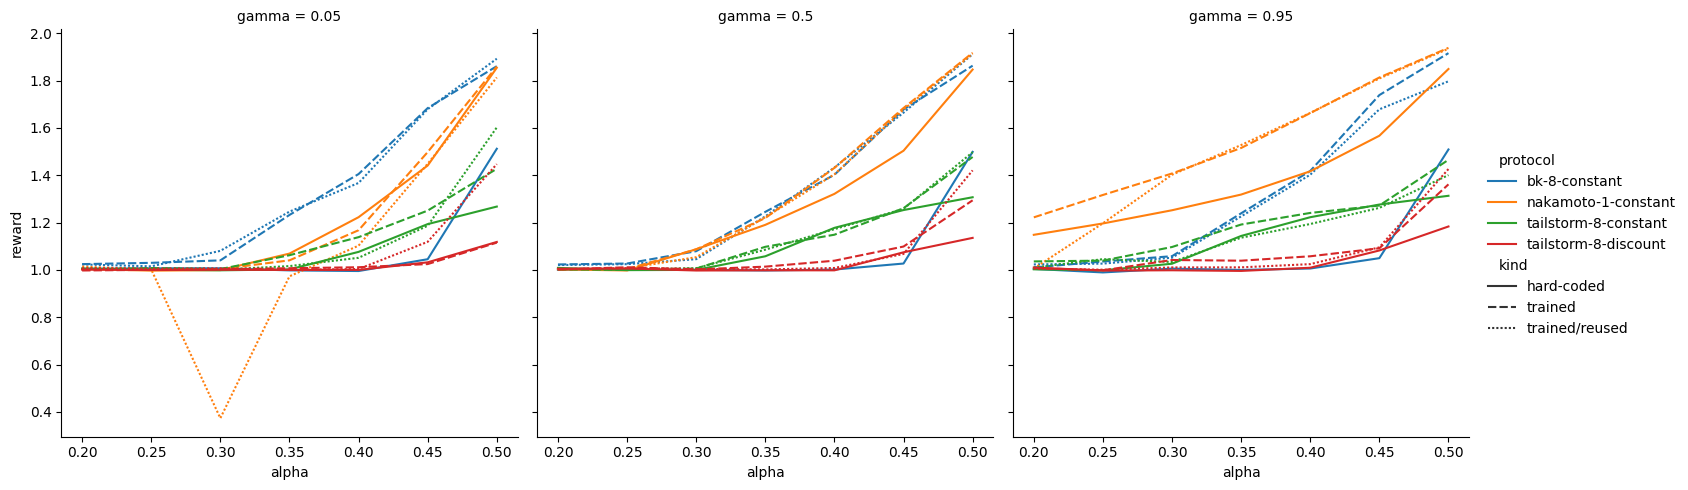

In [13]:
def rl_vs_hard_coded_alpha_lp(objective, label="reward"):
    d = (
        opt_episodes.groupby(
            [
                "protocol",
                "k",
                "reward",
                "subblock_selection",
                "alpha",
                "gamma",
                "kind",
                "reused",
                "policy",
            ]
        )
        .mean()
        .reset_index()
    )
    d.loc[d.reused, "kind"] = "trained/reused"
    d = (
        d.assign(
            protocol=d.protocol + "-" + d.k.map(str) + "-" + d.reward,
            kind=d.kind.astype("category"),
            __=objective(d),
        )
        .drop(columns=[label], errors="ignore")
        .rename(columns=dict(__=label))
    )
    g = sns.relplot(
        data=d,
        kind="line",
        hue="protocol",
        col="gamma",
        x="alpha",
        y=label,
        style="kind",
    )


rl_vs_hard_coded_alpha_lp(
    lambda d: d.episode_reward_attacker / d.episode_progress / d.alpha
)

# Honest or Attack?

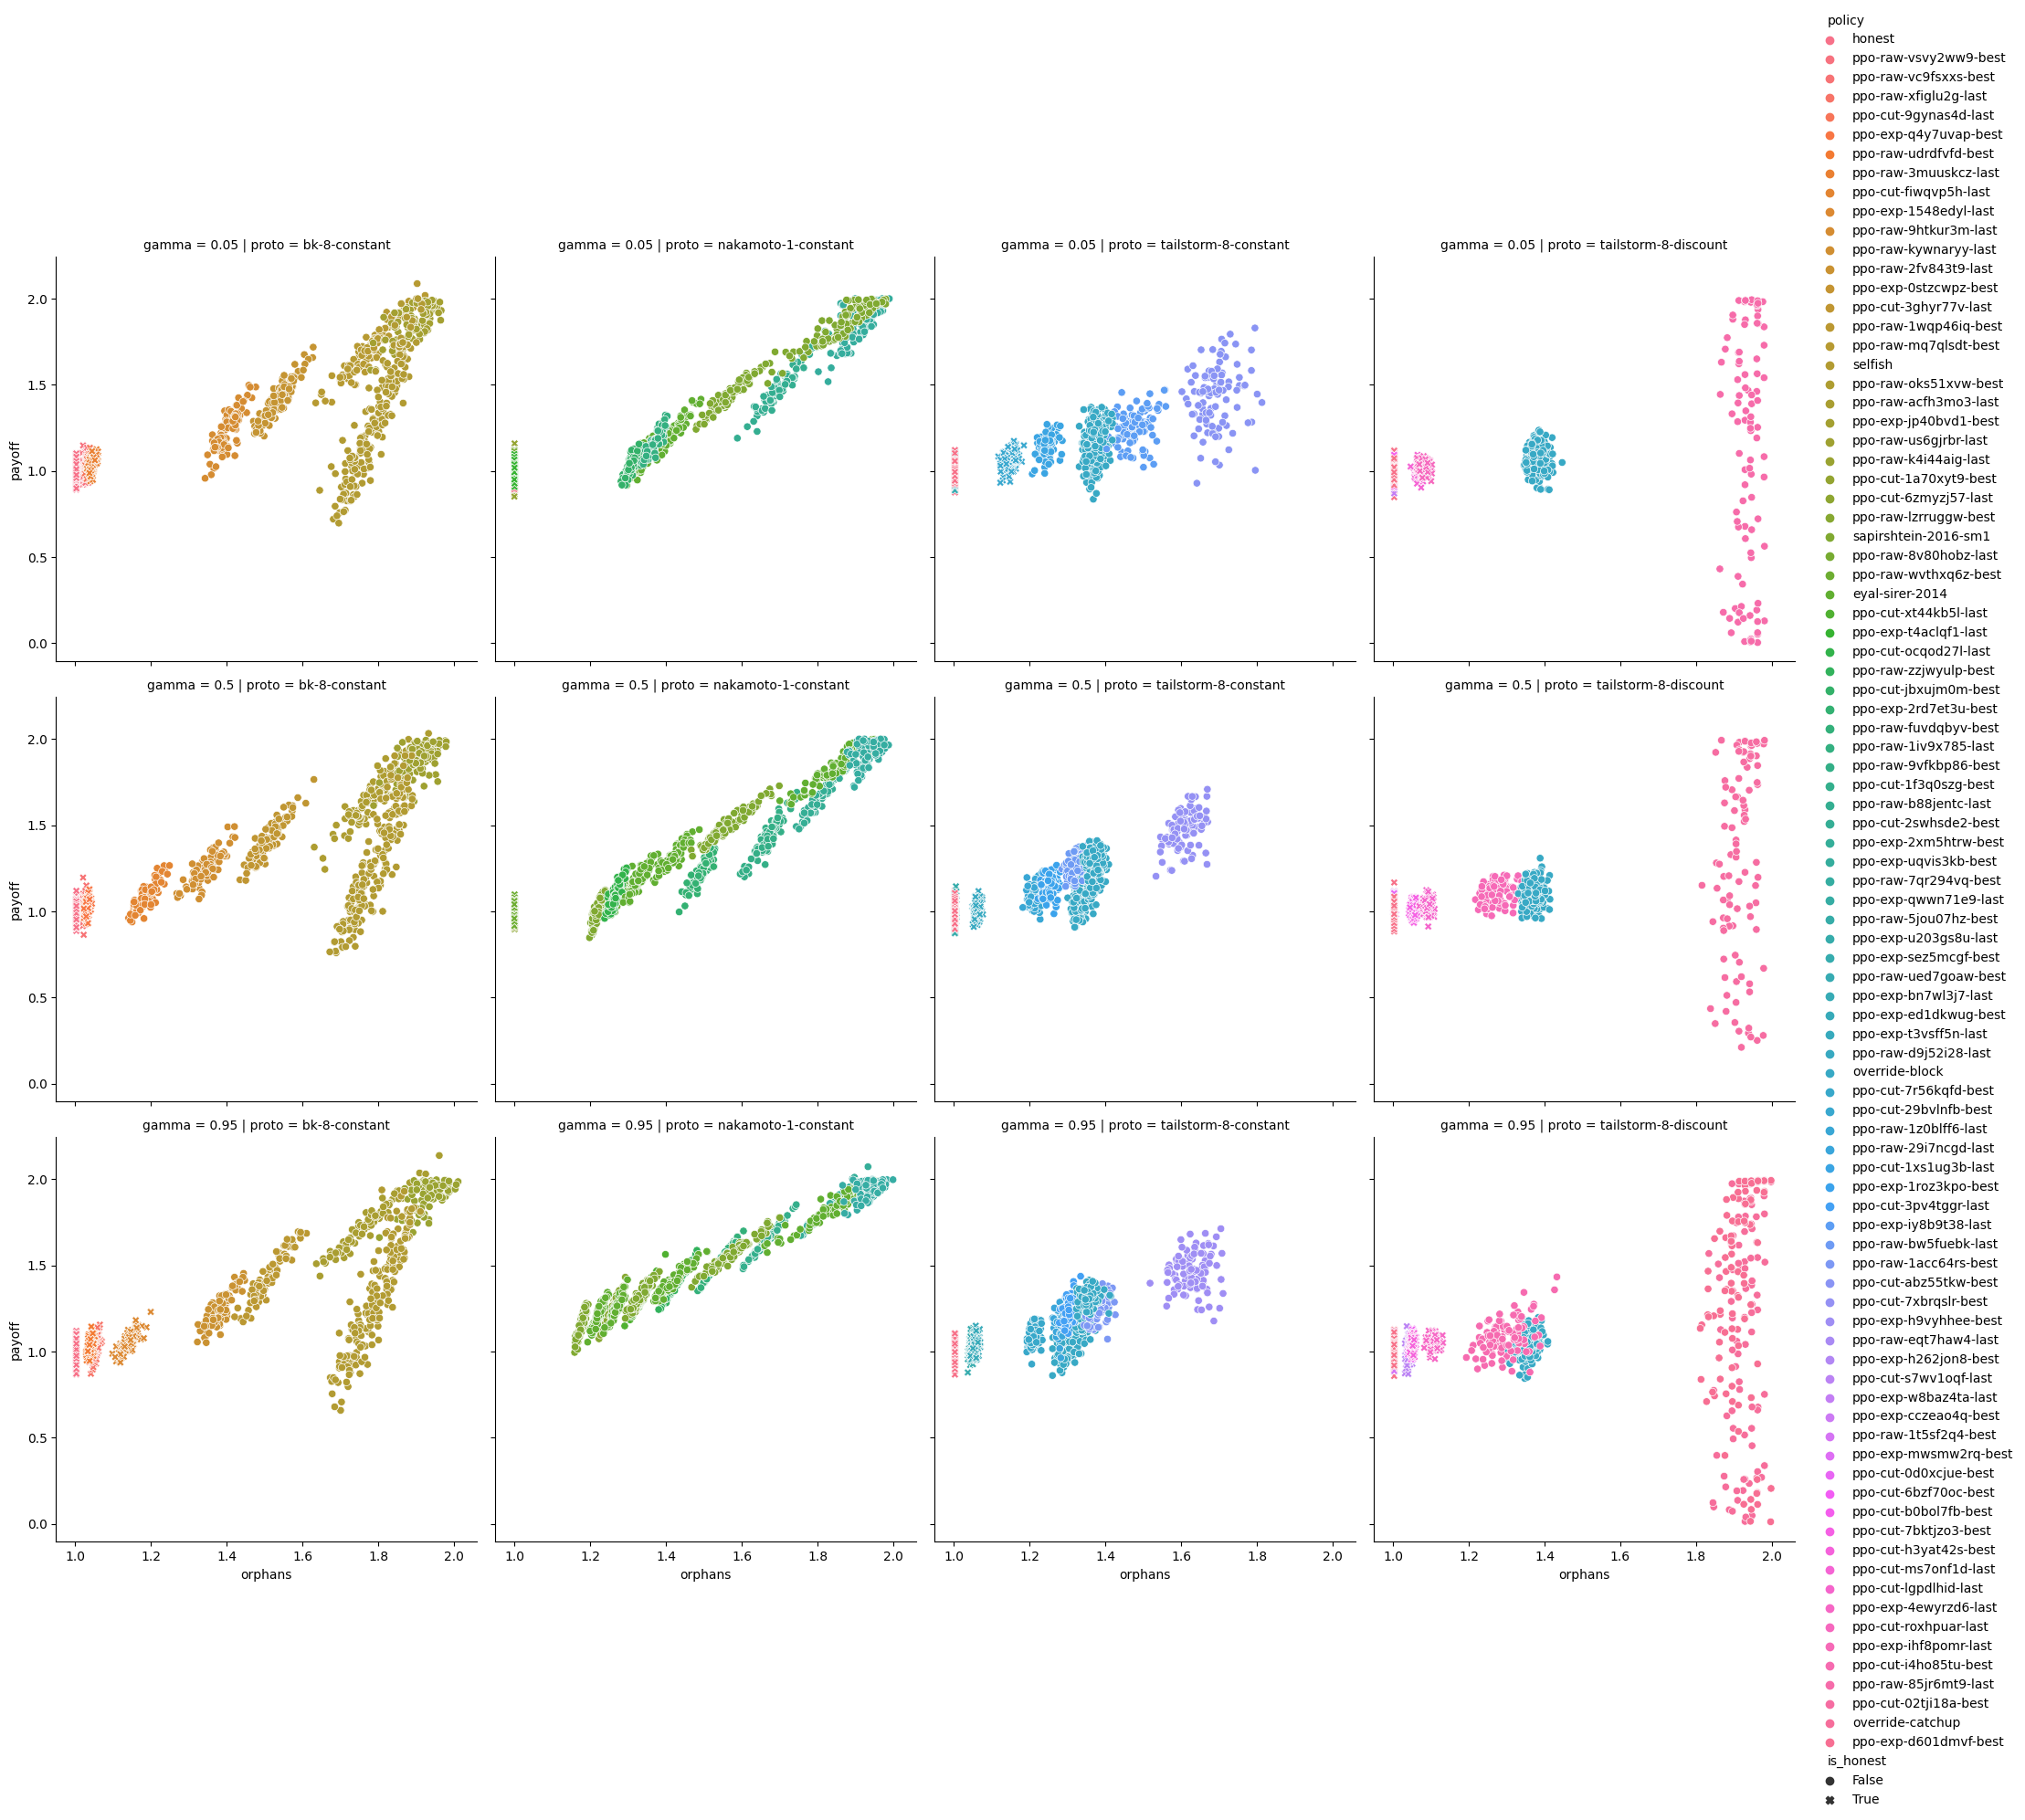

In [14]:
grouping = ["protocol", "k", "reward", "subblock_selection", "alpha", "gamma", "policy"]
d = opt_episodes.query("not reused")
d = d.assign(
    orphans=d.episode_n_activations / d.episode_progress,
    proto=d.protocol + "-" + d.k.map(str) + "-" + d.reward,
    payoff=d.episode_reward_attacker / d.episode_progress / d.alpha,
)
dd = d.groupby(grouping).agg(
    mean_orphans=("orphans", "mean"),
    mean_payoff=("payoff", "mean"),
    std_payoff=("payoff", "std"),
)
d = d.set_index(grouping + ["episode"]).join(dd).reset_index()
d = d.assign(is_honest=d.mean_orphans <= 1.15)
sns.relplot(
    data=d,
    x="orphans",
    y="payoff",
    hue="policy",
    style="is_honest",
    row="gamma",
    col="proto",
)
honest_or_attack_episodes = d  # for later use
# list(d.columns)

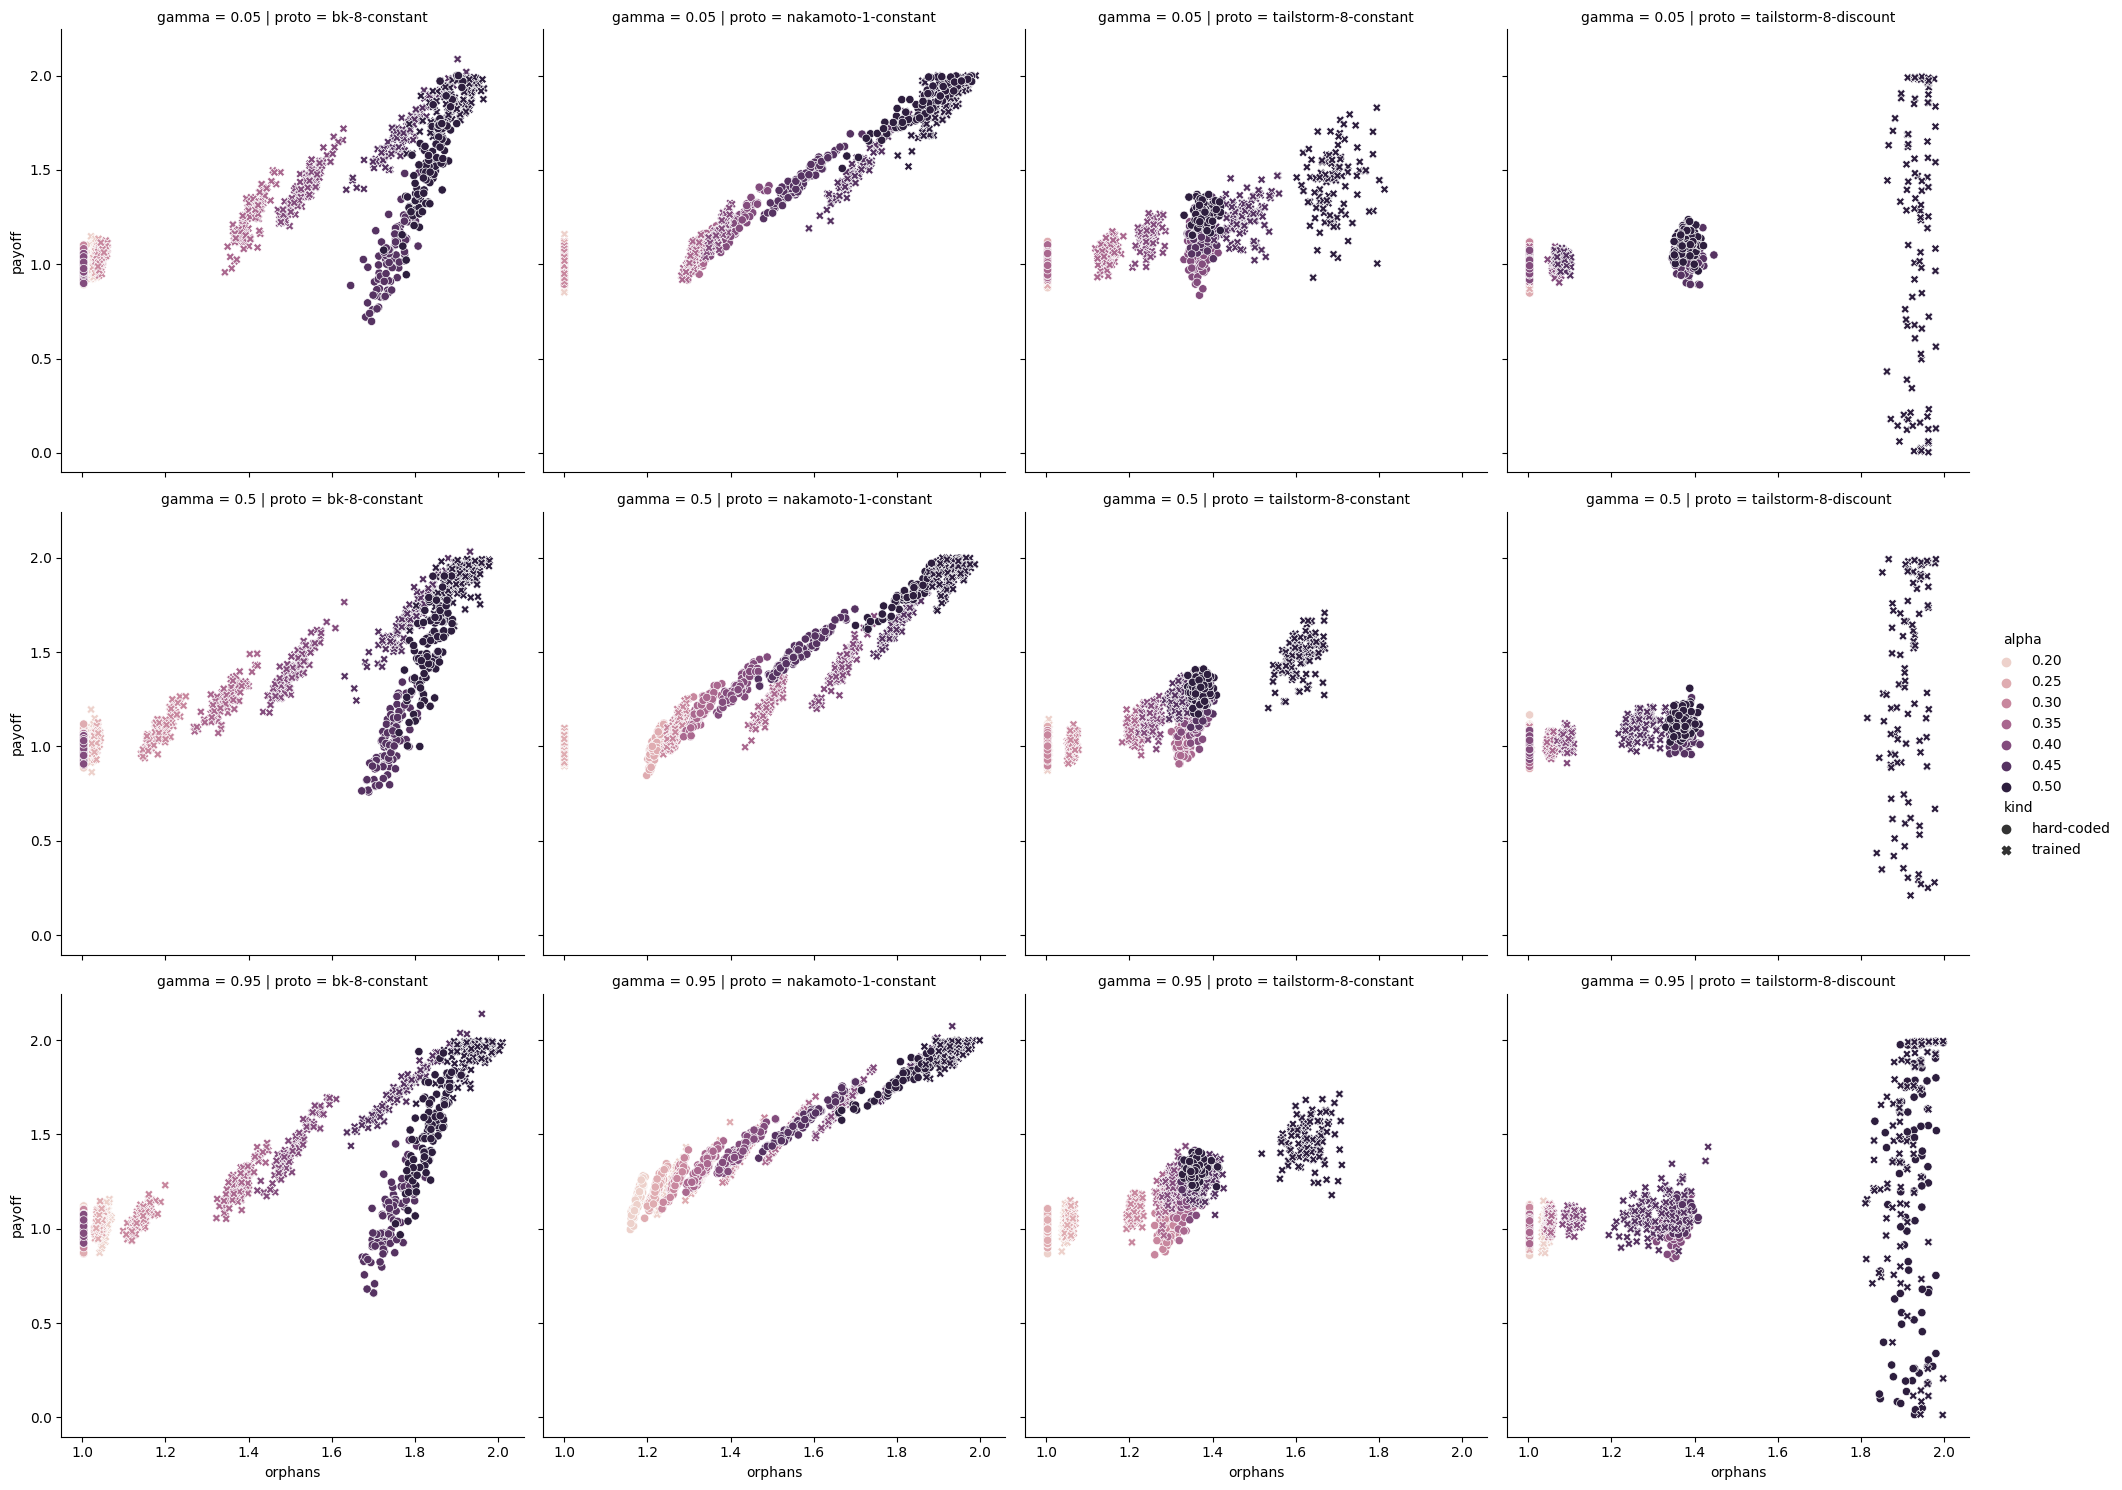

In [15]:
sns.relplot(
    data=d,
    x="orphans",
    y="payoff",
    hue="alpha",
    style="kind",
    row="gamma",
    col="proto",
)

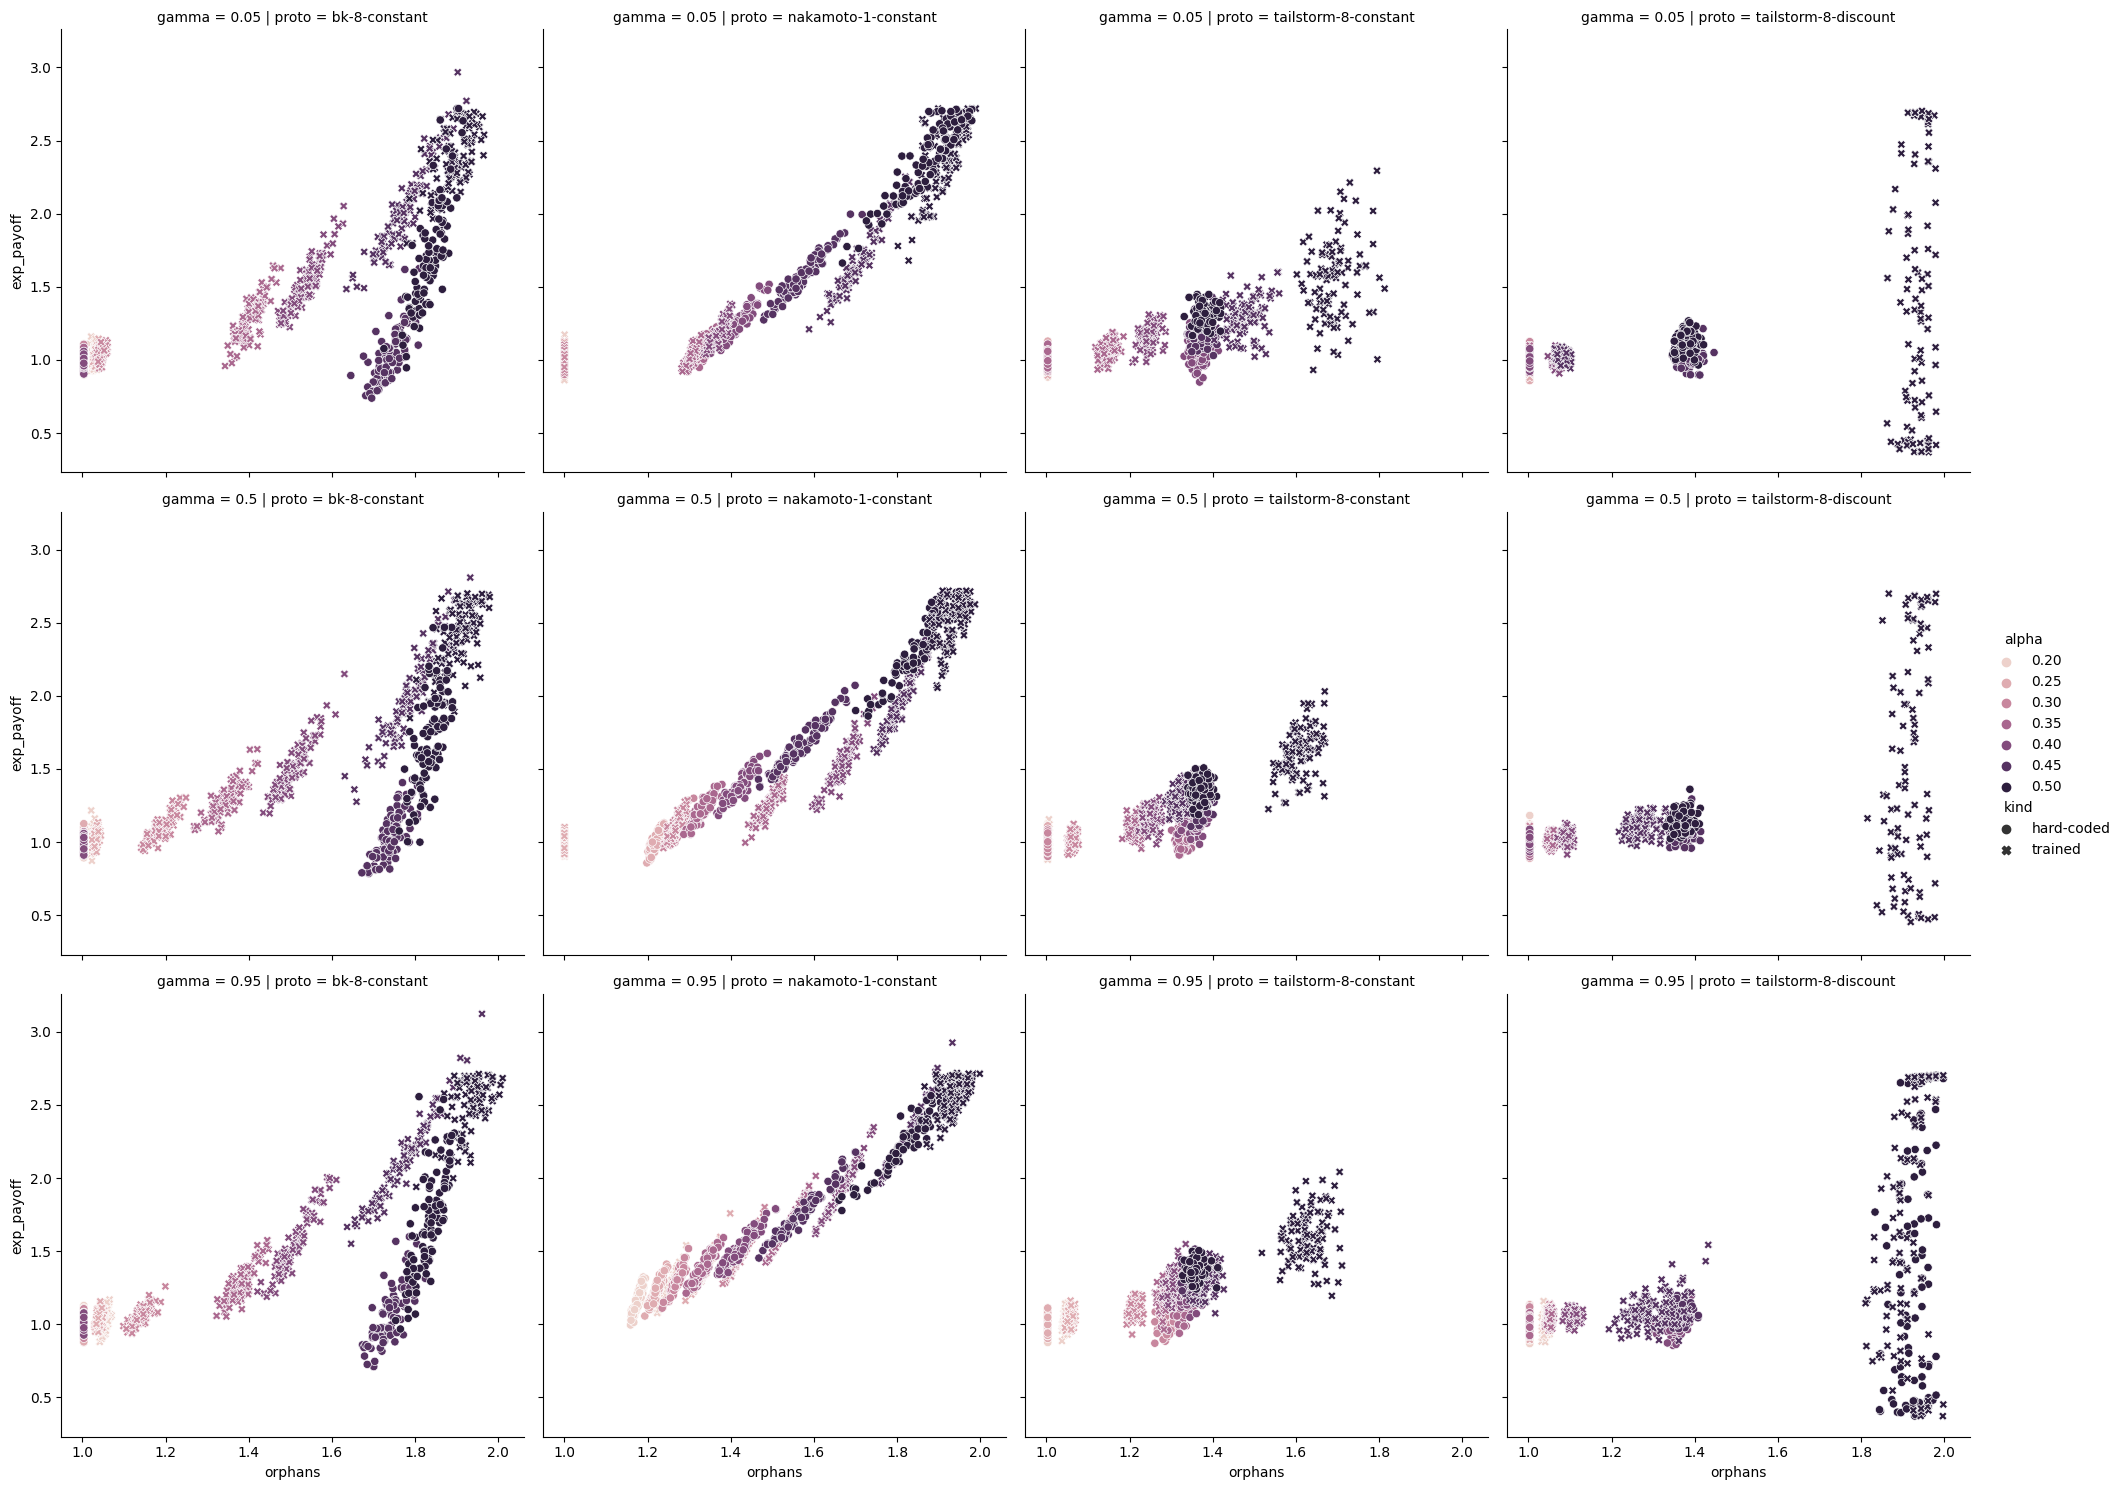

In [16]:
sns.relplot(
    data=d.assign(exp_payoff=np.exp(d.payoff - 1)),
    x="orphans",
    y="exp_payoff",
    hue="alpha",
    style="kind",
    row="gamma",
    col="proto",
)

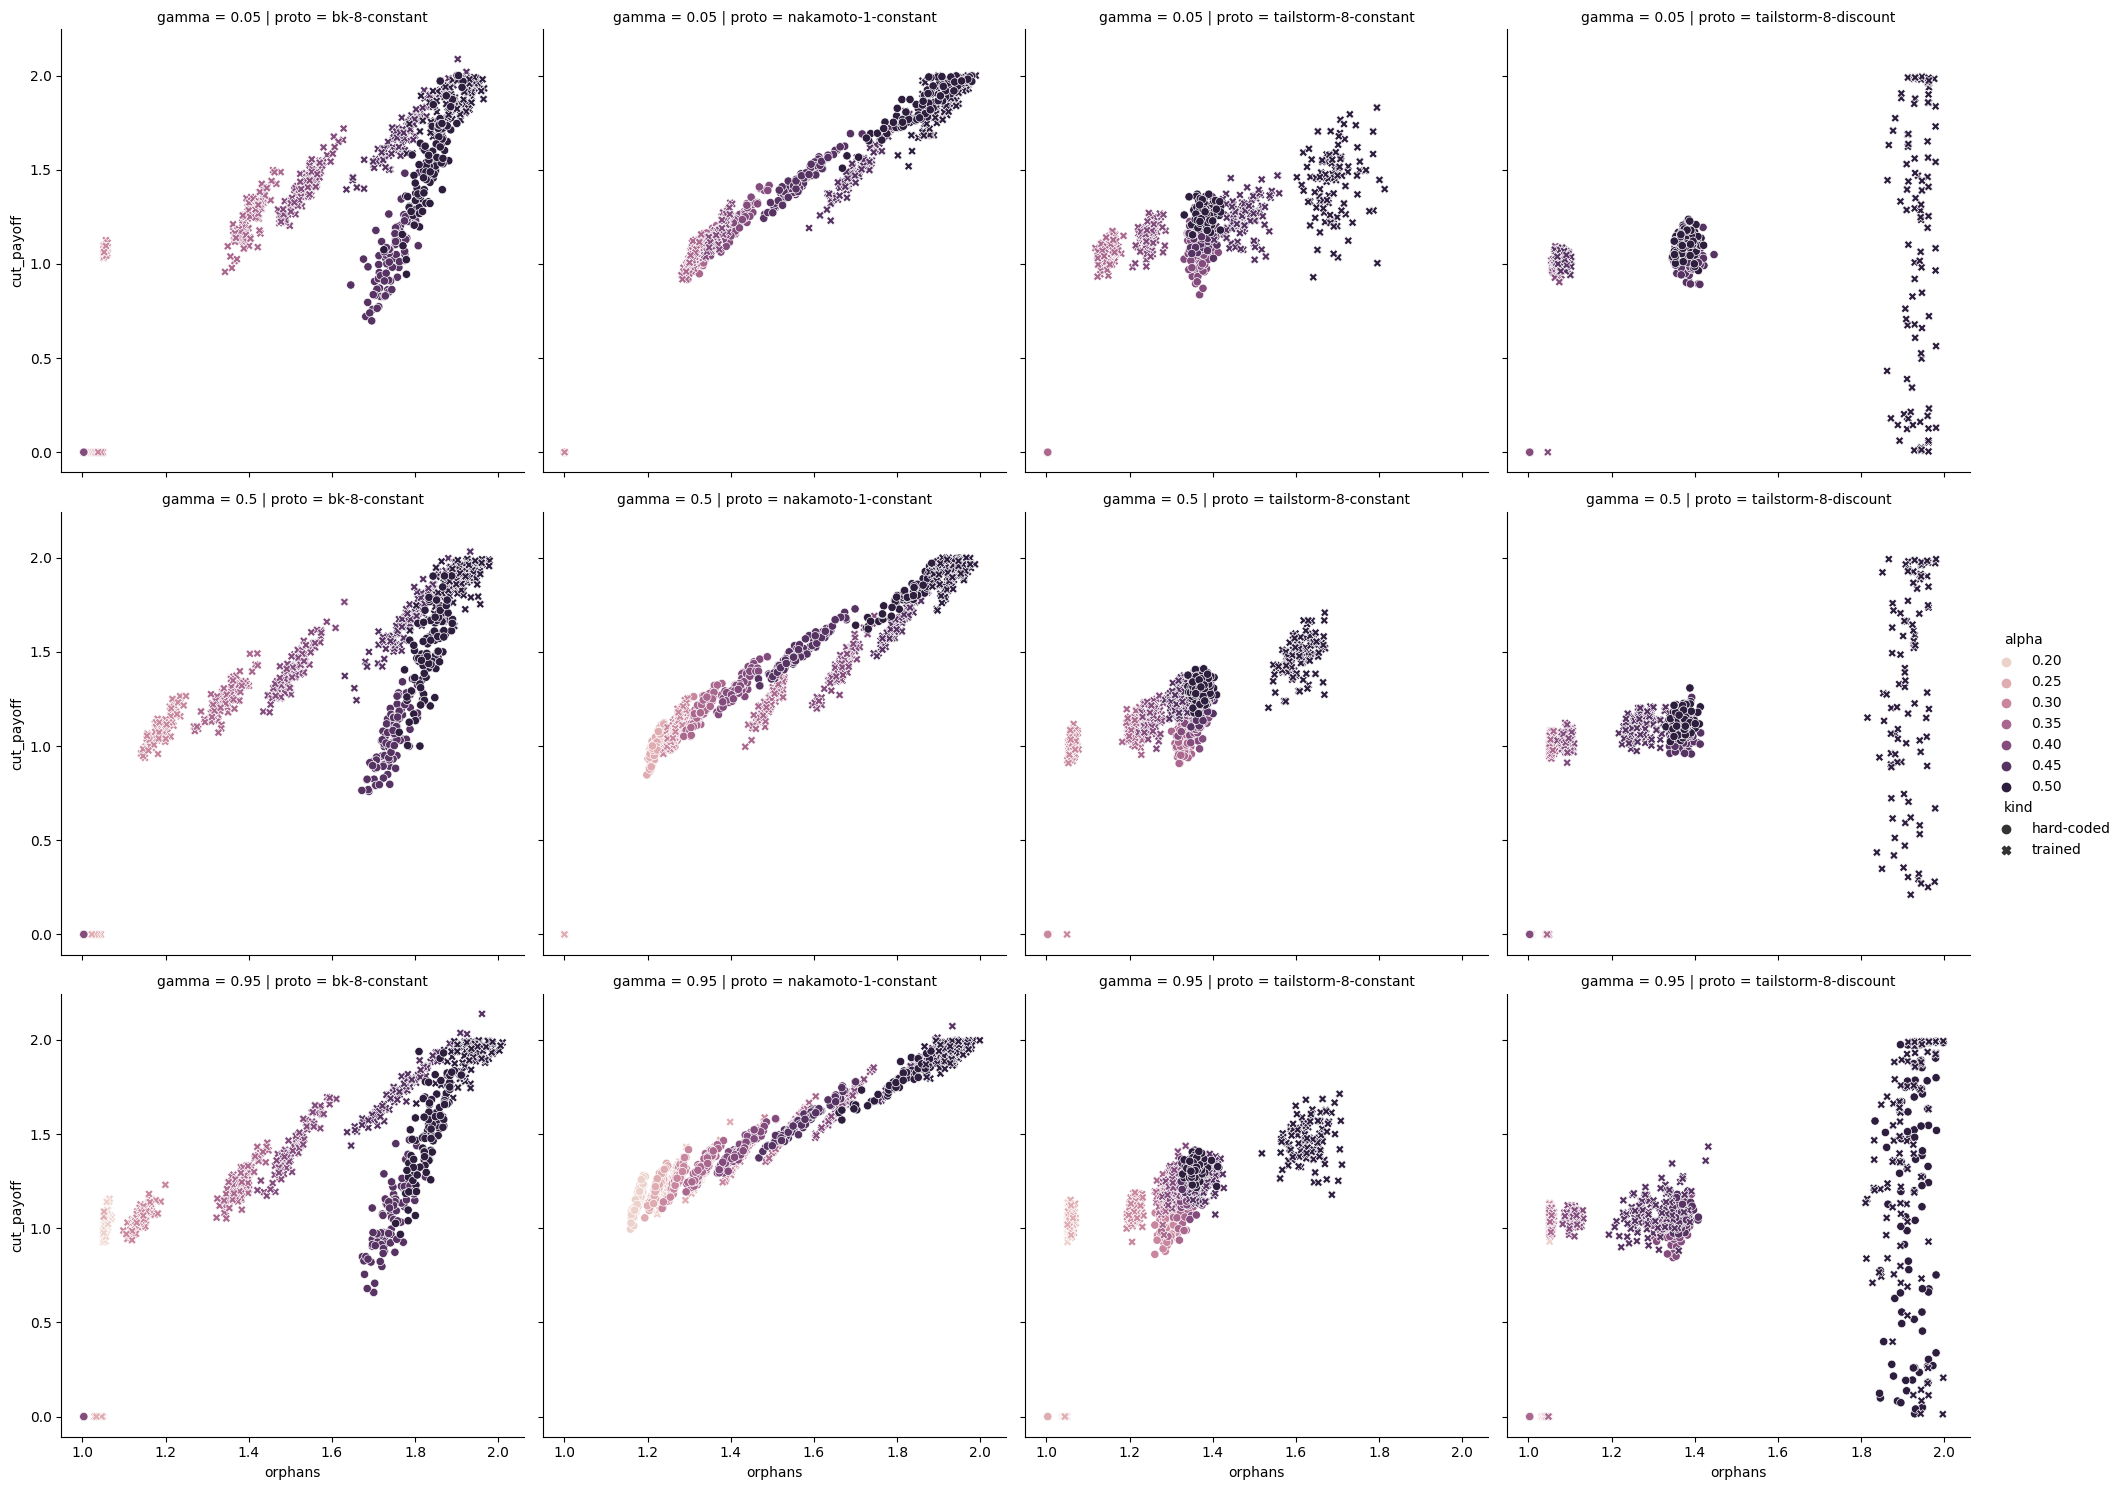

In [17]:
sns.relplot(
    data=d.assign(
        cut_payoff=[x.payoff if x.orphans > 1.05 else 0 for _, x in d.iterrows()]
    ),
    x="orphans",
    y="cut_payoff",
    hue="alpha",
    style="kind",
    row="gamma",
    col="proto",
)

# Break-even point

Per protocol and gamma, we proceed as follows:
1. grid-search the lowest relative hash rate $\hat{\alpha}$, where best policy $P$ produces some orphans
2. $P$ should be the first profitable policy after the break-even point
3. derive policy $P_\hat{\alpha}$ from $P$ by hard-wiring $\hat{\alpha}$ in the observation
4. evaluate $P_\hat{\alpha}$ on full range of alphas
    1. set loss funtcion `loss(alpha) = abs(reward_attacker / episode_progress / alpha - 1)`
    2. minimize loss function with Bayesian optimization

In [18]:
grouping = ["protocol", "k", "reward", "subblock_selection", "gamma", "kind"]
select = ["policy", "reused", "path"]
d = honest_or_attack_episodes.query("is_honest == False and reused==False")
d = d[grouping + ["alpha"] + select].drop_duplicates().reset_index(drop=True)
d = d.loc[d.groupby(grouping).alpha.idxmin()].reset_index(drop=True)
be_policies = d
display(be_policies.drop(columns="path"))

protocol  k    reward subblock_selection  gamma        kind  alpha  \
0          bk  8  constant                n/a   0.05  hard-coded   0.45   
1          bk  8  constant                n/a   0.05     trained   0.35   
2          bk  8  constant                n/a   0.50  hard-coded   0.45   
3          bk  8  constant                n/a   0.50     trained   0.30   
4          bk  8  constant                n/a   0.95  hard-coded   0.45   
5          bk  8  constant                n/a   0.95     trained   0.35   
6    nakamoto  1  constant                n/a   0.05  hard-coded   0.35   
7    nakamoto  1  constant                n/a   0.05     trained   0.35   
8    nakamoto  1  constant                n/a   0.50  hard-coded   0.25   
9    nakamoto  1  constant                n/a   0.50     trained   0.30   
10   nakamoto  1  constant                n/a   0.95  hard-coded   0.20   
11   nakamoto  1  constant                n/a   0.95     trained   0.20   
12  tailstorm  8  constant          heuristic   0.05  hard-coded   0.40   
13  tailstorm  8  constant          heuristic   0.05     trained   0.40   
14  tailstorm  8  constant          heuristic   0.50  hard-coded   0.35   
15  tailstorm  8  constant          heuristic   0.50     trained   0.35   
16  tailstorm  8  constant          heuristic   0.95  hard-coded   0.30   
17  tailstorm  8  constant          heuristic   0.95     trained   0.30   
18  tailstorm  8  discount          heuristic   0.05  hard-coded   0.45   
19  tailstorm  8  discount          heuristic   0.05     trained   0.50   
20  tailstorm  8  discount          heuristic   0.50  hard-coded   0.45   
21  tailstorm  8  discount          heuristic   0.50     trained   0.45   
22  tailstorm  8  discount          heuristic   0.95  hard-coded   0.40   
23  tailstorm  8  discount          heuristic   0.95     trained   0.45   

                   policy  reused  
0                 selfish   False  
1   ppo-raw-9htkur3m-last   False  
2                 selfish   False  
3   ppo-cut-fiwqvp5h-last   False  
4                 selfish   False  
5   ppo-raw-2fv843t9-last   False  
6         eyal-sirer-2014   False  
7   ppo-cut-jbxujm0m-best   False  
8    sapirshtein-2016-sm1   False  
9   ppo-cut-ocqod27l-last   False  
10   sapirshtein-2016-sm1   False  
11  ppo-raw-lzrruggw-best   False  
12         override-block   False  
13  ppo-cut-1xs1ug3b-last   False  
14         override-block   False  
15  ppo-raw-1z0blff6-last   False  
16         override-block   False  
17  ppo-cut-7r56kqfd-best   False  
18         override-block   False  
19  ppo-raw-85jr6mt9-last   False  
20         override-block   False  
21  ppo-exp-ihf8pomr-last   False  
22         override-block   False  
23  ppo-cut-i4ho85tu-best   False

In [19]:
import break_even


def find_break_even_row(x, **kwargs):
    kwargs |= env_kwargs_of_row(x)
    kwargs["episode_len"] = 8192  # quality of each point
    kwargs["n_calls"] = 42  # how many points
    kwargs[
        "title"
    ] = f"{x.protocol}({x.k}, {x.reward}, {x.subblock_selection})  γ={x.gamma}  {x.policy}"
    if x.kind == "trained":
        res = break_even.find_trained(env_name, x.path, **kwargs)
    elif x.kind == "hard-coded":
        res = break_even.find_hardcoded(env_name, x.policy, **kwargs)
    else:
        assert False
    return pd.Series(res)


# d = be_policies.query("protocol == 'nakamoto'")
# d = be_policies.loc[[2]]
d = be_policies

# results = d.progress_apply(find_break_even_row, axis = 1)
with threadpoolctl.threadpool_limits(limits=1):
    results = d.parallel_apply(find_break_even_row, axis=1)
be_points = pd.concat([d, results], axis=1)

In [20]:
be_points.drop(columns=["path", "break_even_png"])

protocol  k    reward subblock_selection  gamma        kind  alpha  \
0          bk  8  constant                n/a   0.05  hard-coded   0.45   
1          bk  8  constant                n/a   0.05     trained   0.35   
2          bk  8  constant                n/a   0.50  hard-coded   0.45   
3          bk  8  constant                n/a   0.50     trained   0.30   
4          bk  8  constant                n/a   0.95  hard-coded   0.45   
5          bk  8  constant                n/a   0.95     trained   0.35   
6    nakamoto  1  constant                n/a   0.05  hard-coded   0.35   
7    nakamoto  1  constant                n/a   0.05     trained   0.35   
8    nakamoto  1  constant                n/a   0.50  hard-coded   0.25   
9    nakamoto  1  constant                n/a   0.50     trained   0.30   
10   nakamoto  1  constant                n/a   0.95  hard-coded   0.20   
11   nakamoto  1  constant                n/a   0.95     trained   0.20   
12  tailstorm  8  constant          heuristic   0.05  hard-coded   0.40   
13  tailstorm  8  constant          heuristic   0.05     trained   0.40   
14  tailstorm  8  constant          heuristic   0.50  hard-coded   0.35   
15  tailstorm  8  constant          heuristic   0.50     trained   0.35   
16  tailstorm  8  constant          heuristic   0.95  hard-coded   0.30   
17  tailstorm  8  constant          heuristic   0.95     trained   0.30   
18  tailstorm  8  discount          heuristic   0.05  hard-coded   0.45   
19  tailstorm  8  discount          heuristic   0.05     trained   0.50   
20  tailstorm  8  discount          heuristic   0.50  hard-coded   0.45   
21  tailstorm  8  discount          heuristic   0.50     trained   0.45   
22  tailstorm  8  discount          heuristic   0.95  hard-coded   0.40   
23  tailstorm  8  discount          heuristic   0.95     trained   0.45   

                   policy  reused  break_even  
0                 selfish   False    0.440664  
1   ppo-raw-9htkur3m-last   False    0.280208  
2                 selfish   False    0.443002  
3   ppo-cut-fiwqvp5h-last   False    0.194607  
4                 selfish   False    0.441819  
5   ppo-raw-2fv843t9-last   False    0.248672  
6         eyal-sirer-2014   False    0.334139  
7   ppo-cut-jbxujm0m-best   False    0.341364  
8    sapirshtein-2016-sm1   False    0.246560  
9   ppo-cut-ocqod27l-last   False    0.247482  
10   sapirshtein-2016-sm1   False    0.100000  
11  ppo-raw-lzrruggw-best   False    0.100000  
12         override-block   False    0.374087  
13  ppo-cut-1xs1ug3b-last   False    0.295818  
14         override-block   False    0.323198  
15  ppo-raw-1z0blff6-last   False    0.259823  
16         override-block   False    0.281920  
17  ppo-cut-7r56kqfd-best   False    0.210797  
18         override-block   False    0.437014  
19  ppo-raw-85jr6mt9-last   False    0.100000  
20         override-block   False    0.410042  
21  ppo-exp-ihf8pomr-last   False    0.367631  
22         override-block   False    0.391851  
23  ppo-cut-i4ho85tu-best   False    0.326272

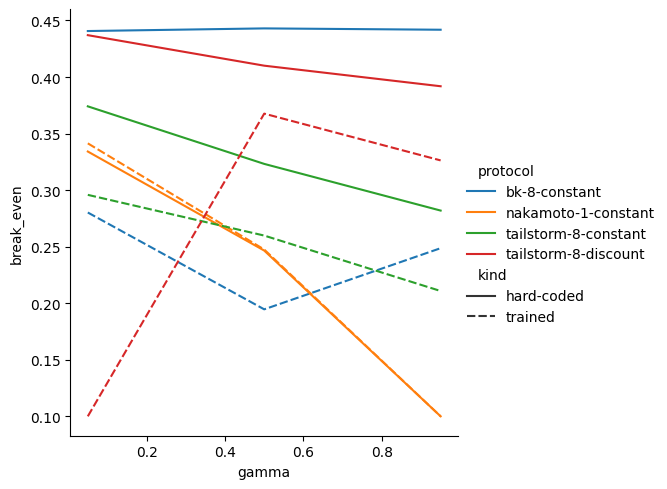

In [21]:
d = be_points.copy()
d.loc[d.reused, "kind"] = "trained/reused"
sns.relplot(
    data=d.assign(
        protocol=d.protocol + "-" + d.k.map(str) + "-" + d.reward,
    ),
    kind="line",
    hue="protocol",
    x="gamma",
    y="break_even",
    style="kind",
)

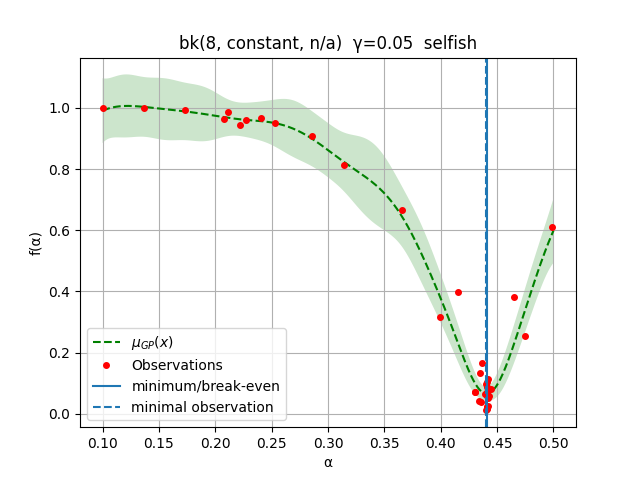

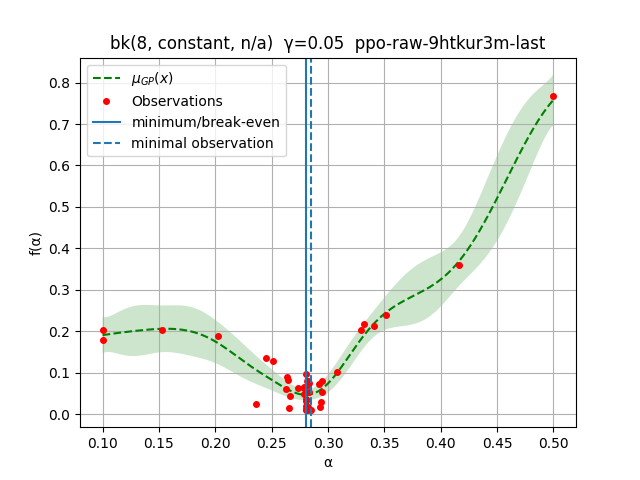

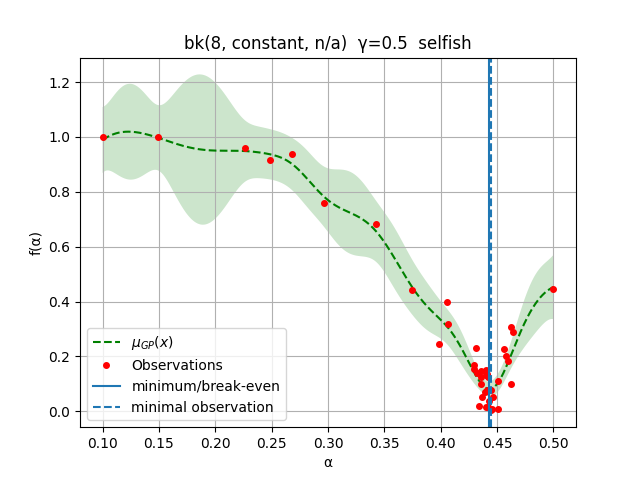

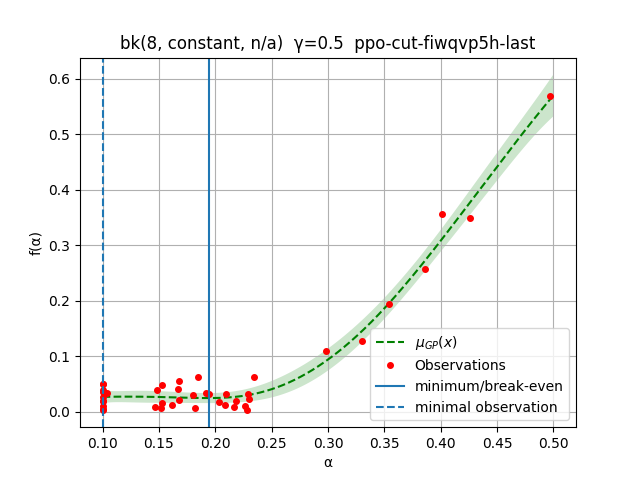

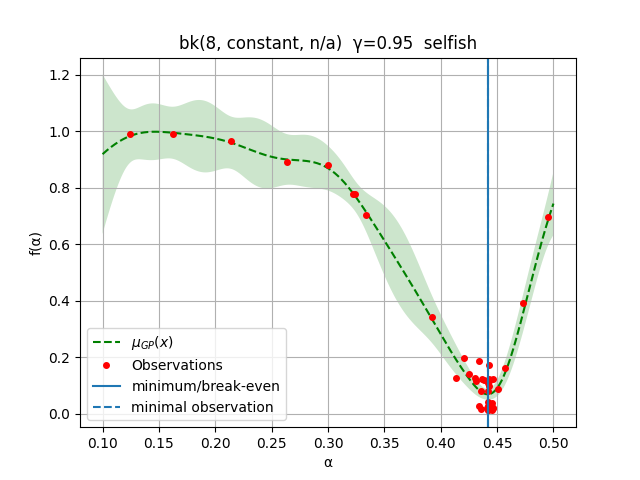

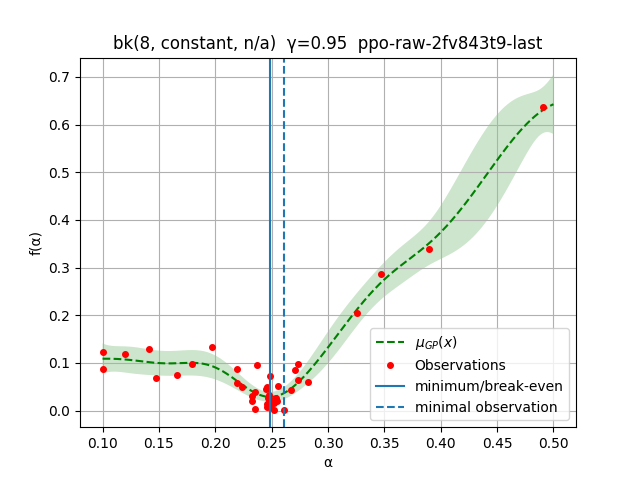

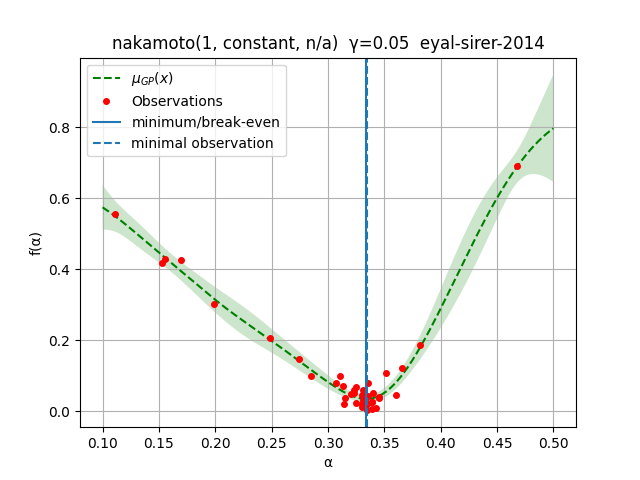

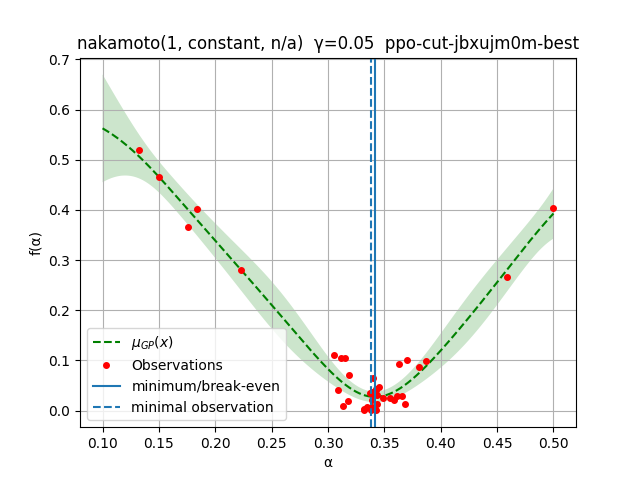

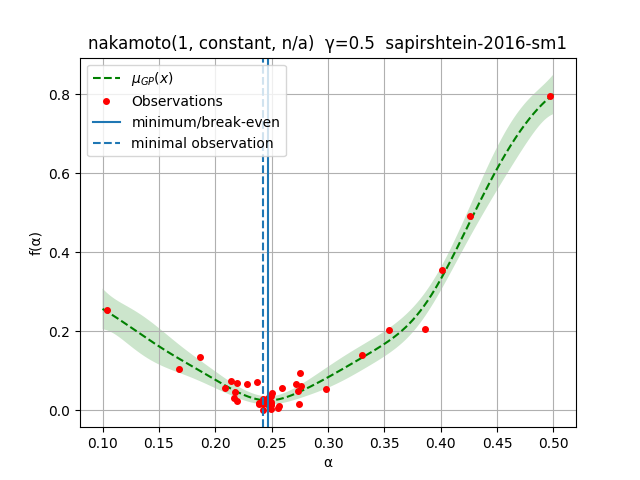

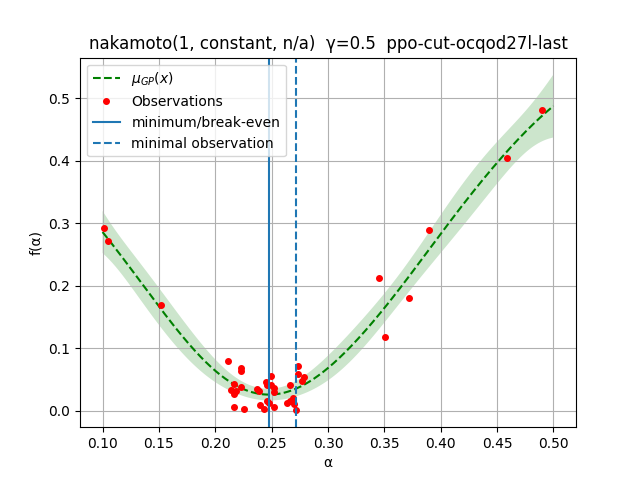

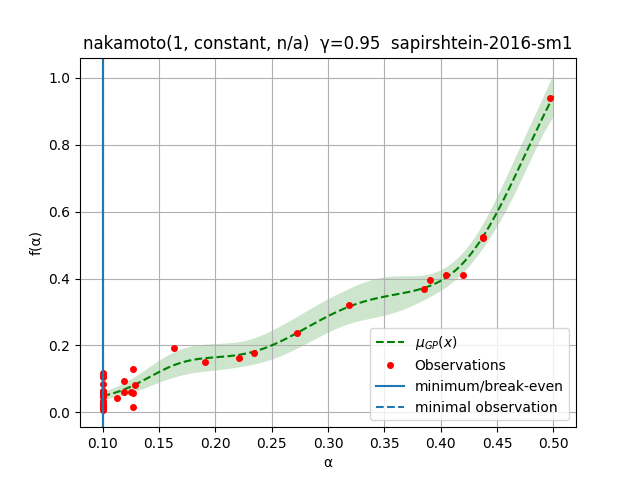

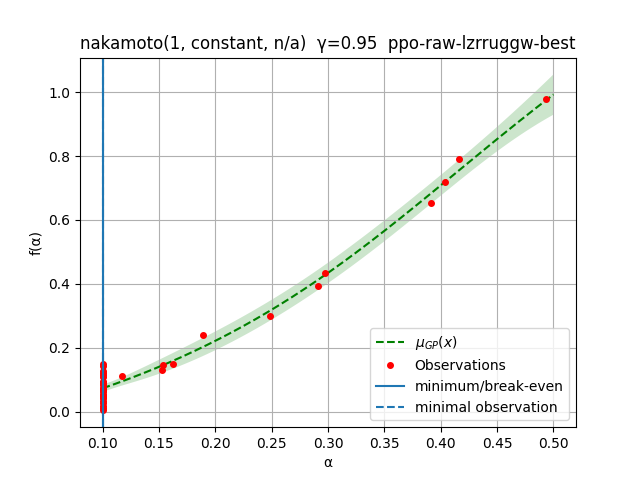

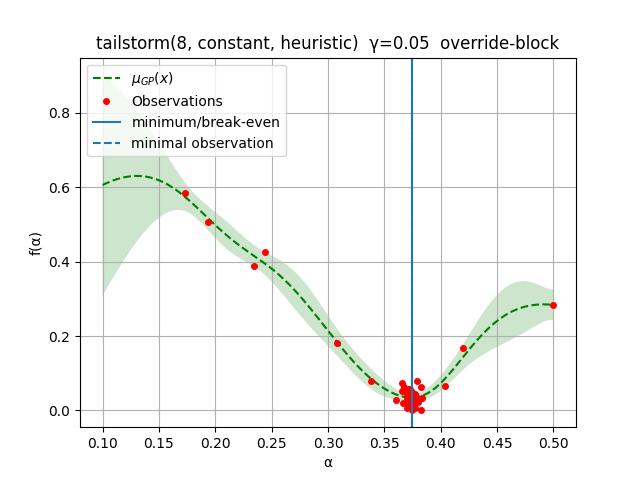

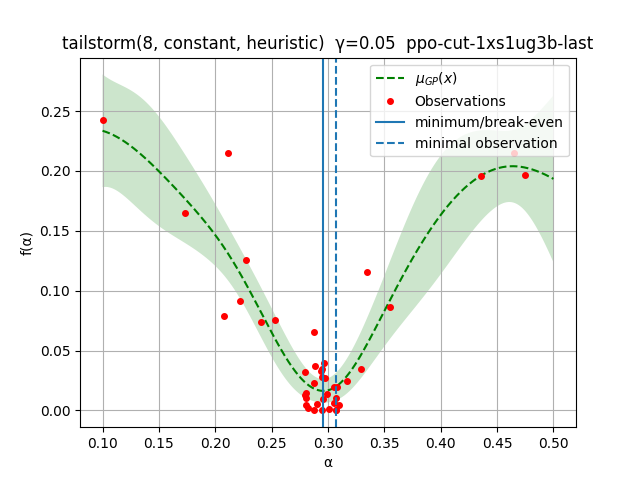

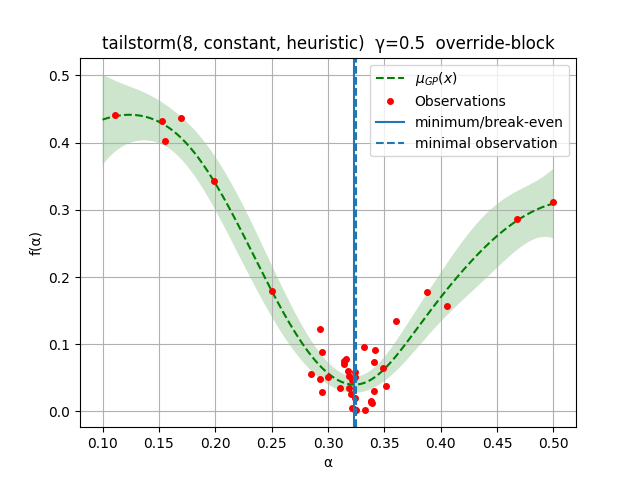

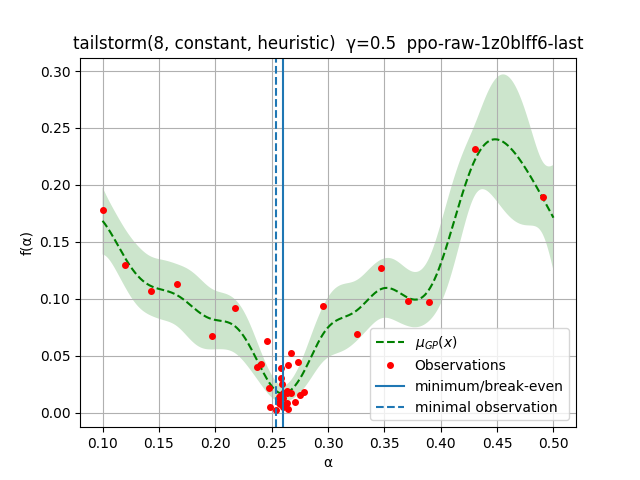

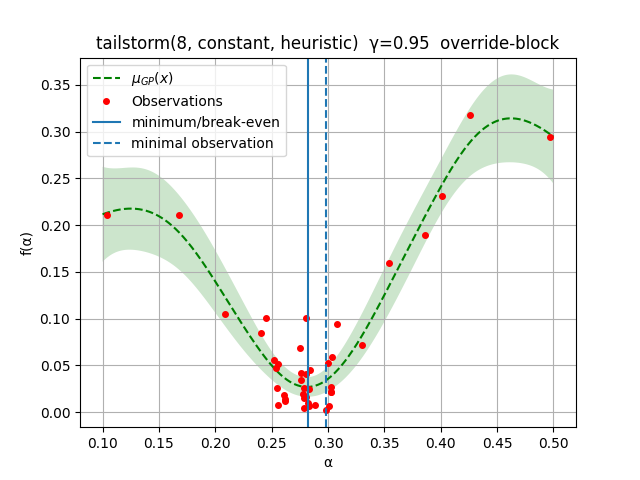

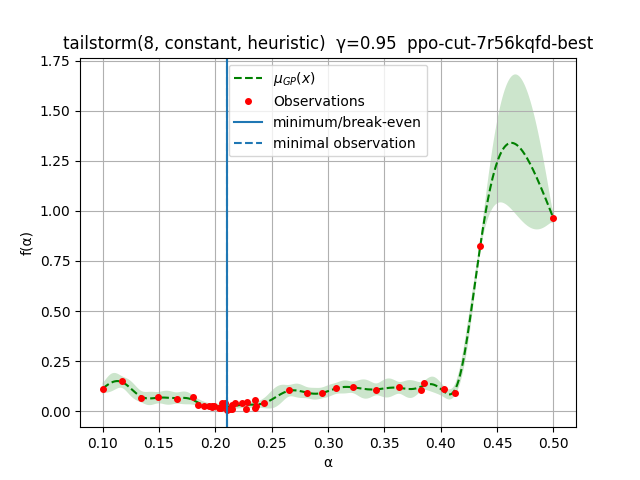

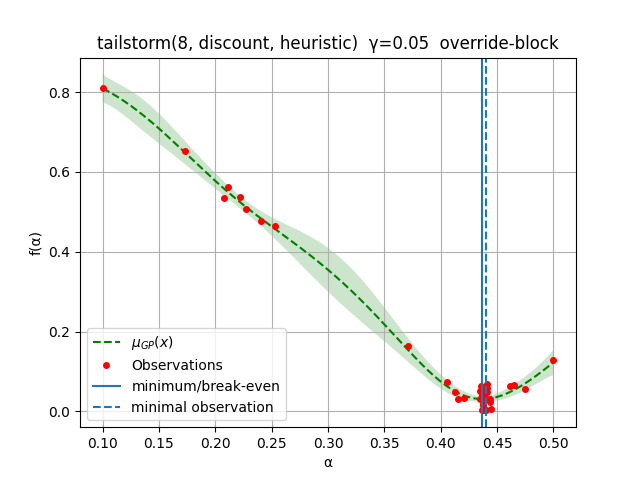

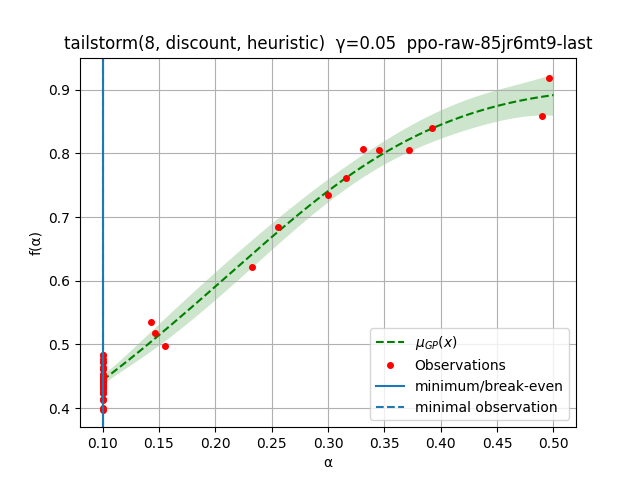

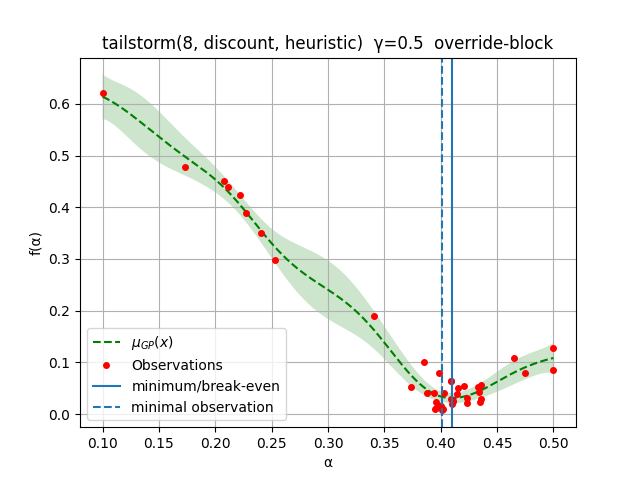

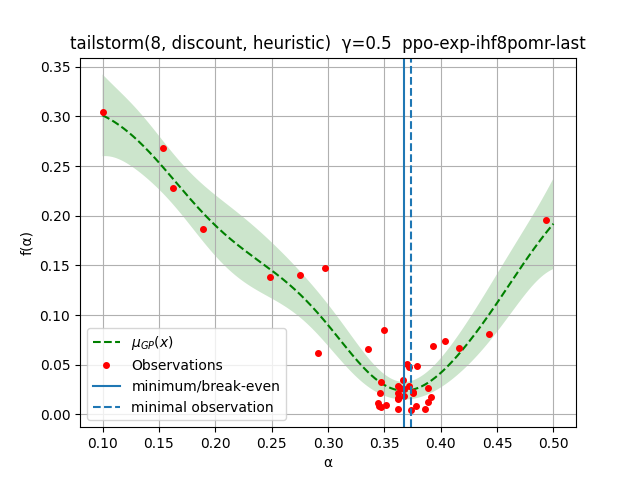

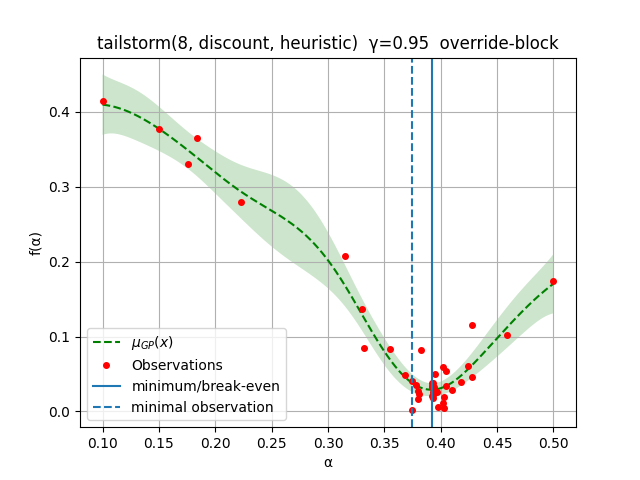

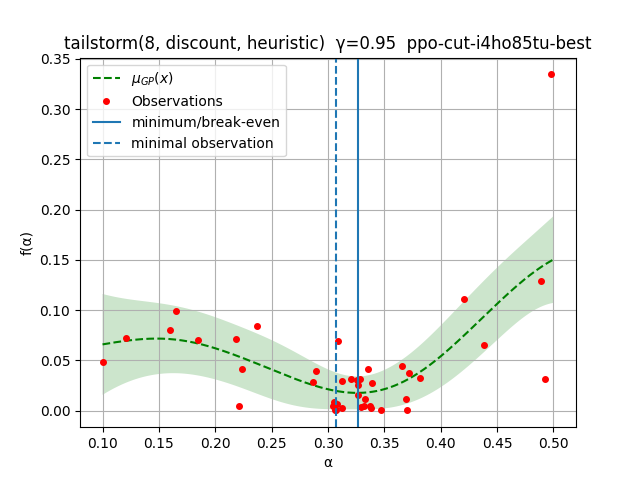

In [22]:
import IPython.display

_ = be_points.break_even_png.apply(
    lambda x: display(IPython.display.Image(data=x, format="png"))
)